In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from fastai.imports import *
from fastai.torch_imports import *

# All the Linear Algebra You Need for AI

## fast.ai teaching philosophy

<img src="images/demba_combustion_engine.png" alt="" style="width: 60%"/>
<center>
(source: [Demba Ba](https://github.com/zalandoresearch/fashion-mnist) and [Arvind Nagaraj](https://medium.com/towards-data-science/thoughts-after-taking-the-deeplearning-ai-courses-8568f132153))
</center>
Top-down, the whole game

**Plan today**
- neural net with nn.torch
- code a neural net ourselves
- look under the hood at broadcasting & matrix multiplication

## Datasets

**Today**: MNIST

<img src="images/mnist.png" alt="" style="width: 60%"/>

### Other datasets

**Fashion MNIST**

<img src="images/fashion-mnist.png" alt="" style="width: 70%"/>
<center>
(source: [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist))
</center>

**CIFAR 10**

<img src="images/cifar10.png" alt="" style="width: 70%"/>
<center>
(source: [Cifar 10](https://github.com/zalandoresearch/fashion-mnist))
</center>

[PyTorch](http://pytorch.org/) is a Python framework for tensors and dynamic neural networks with GPU acceleration.  Many of the core contributors work on Facebook's AI team.  In many ways, it is similar to Numpy, only with the increased parallelization of using a GPU.

From the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [learning by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

**Note about GPUs**: If you are not using a GPU, you will need to remove the `.cuda()` from the methods below. GPU usage is not required for this course, but I thought it would be of interest to some of you.  To learn how to create an AWS instance with a GPU, you can watch the [fast.ai setup lesson](http://course.fast.ai/lessons/aws.html).]

## Getting Started

### Data and Imports

In [4]:
from fastai.io import *

In [5]:
path = '../data/'

In [6]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [7]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), (x_test, y_test)) = load_mnist(path+FILENAME)

One of the challenges in training neural networks is keeping your numbers from exploding (going to infinity) or vanishing (going to zero).  There are several different ways to add normalization to address this.

#### Calculate Mean and Standard Deviation in order to normalize

In [8]:
mean = x.mean()
std = x.std()

In [9]:
x=(x-mean)/std
x.mean(), x.std()

(-3.1638146e-07, 0.99999934)

In [10]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

#### Helper methods

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [12]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation='none', cmap='gray')

### Look at the data

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

In [45]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

We can look at part of an image:

In [46]:
x_imgs[0,10:15,10:15]

array([[-0.4245, -0.4245, -0.4245, -0.4245,  0.1729],
       [-0.4245, -0.4245, -0.4245,  0.7831,  2.4357],
       [-0.4245, -0.272 ,  1.2026,  2.7789,  2.8043],
       [-0.4245,  1.7619,  2.8043,  2.8043,  1.7365],
       [-0.4245,  2.2069,  2.8043,  2.8043,  0.4018]], dtype=float32)

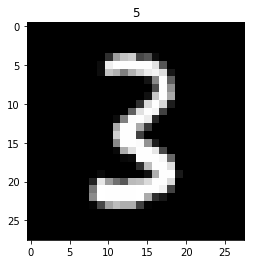

In [47]:
show(x_imgs[0], y[0])

It's the digit 5!  And that's stored in the y value:

In [48]:
y[0]

5

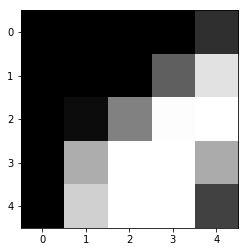

In [49]:
show(x_imgs[0,10:15,10:15])

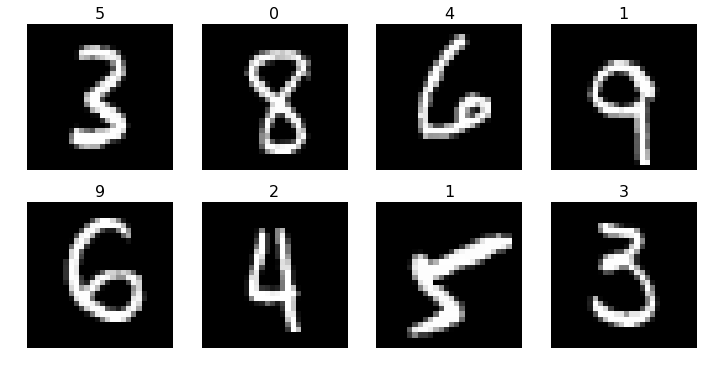

In [50]:
plots(x_imgs[:8], titles=y[:8])

## Neural Net (with nn.torch)

In [32]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.core import *

import torch.nn as nn

In [20]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

We will start with a simple neural network.  Neural networks typically consist of linear layers alternating with non-linear layers.

Each input is a vector of size $28\times 28$ pixels and our output is of size $10$ (since there are 10 digits: 0, 1, ..., 9).

I just chose $256$ as the number of hidden states, you could change this to something else.

In [21]:
net = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).cuda()

- **Loss**: what function is the optimizer trying to minimize?  We need to say how we're defining the error.
- **Optimizer**: algorithm for finding the minimum. typically these are variations on *stochastic gradient descent*, involve taking a step that appears to be the right direction based on the gradient
- **Metrics**: other calculations you want to see as you train

In [33]:
loss=F.cross_entropy
metrics=[accuracy]
opt=optim.Adam(net.parameters())

In [35]:
fit(net, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

A Jupyter Widget

A Jupyter Widget

[ 0.0738  0.0902  0.9734]


In [39]:
preds = predict(net, md.val_dl)

In [40]:
preds[0]


-10.7573
 -0.4874
 -2.9886
 10.8849
-13.7706
  1.7876
-10.2757
-12.6573
 -2.3250
 -8.3576
[torch.FloatTensor of size 10]

In [41]:
preds = preds.max(1)[1]

Let's see how some of our preditions look!

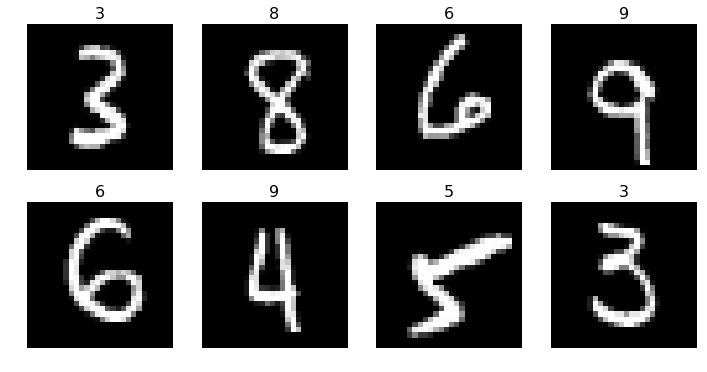

In [51]:
plots(x_imgs[:8], titles=preds[:8])

## Coding the Neural Net ourselves

A Tensor is a *multi-dimensional matrix containing elements of a single data type*: a group of data, all with the same type (e.g. A Tensor could store a 4 x 4 x 6 matrix of 32-bit signed integers).

In [55]:
from torch.autograd import Variable
def get_weights(*dims): return nn.Parameter(torch.randn(*dims)/dims[0])

We will define the neural network ourselves.  Forward describes how the neural net converts inputs --> outputs

In [56]:
class SimpleMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 256)  # Layer 1 weights
        self.l1_b = get_weights(256)   # Layer 1 bias
        self.l2_w = get_weights(256, 10)  # Layer 2 weights
        self.l2_b = get_weights(10)   # Layer 2 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.mm(x, self.l1_w) + self.l1_b
        x = x * (x > 0).float()
        x = torch.mm(x, self.l2_w) + self.l2_b
        return x

In [63]:
net2 = SimpleMnist().cuda()
opt=optim.Adam(net2.parameters())

In [64]:
fit(net2, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

A Jupyter Widget

A Jupyter Widget

[ 0.1775  0.1404  0.9584]


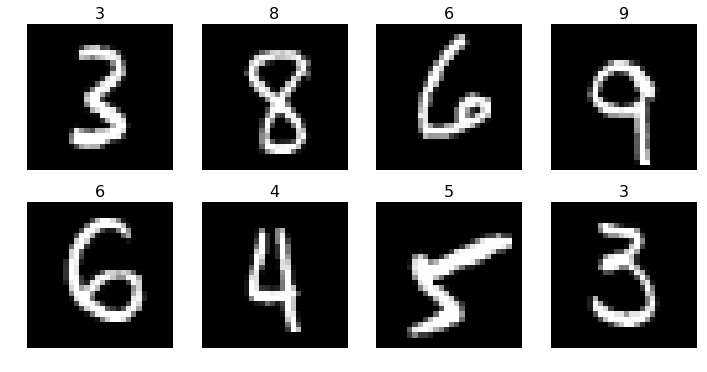

In [66]:
preds = predict(net2, md.val_dl).max(1)[1]
plots(x_imgs[:8], titles=preds[:8])

## what torch.mm (matrix multiplication) is doing

Now let's dig in to what we were doing with `torch.mm`: matrix multiplication.  First, let's start with a simpler building block: **broadcasting**.

### Broadcasting

#### Background

Broadcasting and element-wise operations are supported in the same way by both numpy and pytorch.

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [50]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7])

In [51]:
a + b

array([12, 14,  3])

In [52]:
a < b

array([False,  True,  True], dtype=bool)

#### Broadcasting with a scalar

In [53]:
a > 0

array([ True,  True, False], dtype=bool)

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

Other examples of broadcasting with a scalar (as we did when we normalized our data):

In [54]:
a + 1

array([11,  7, -3])

In [55]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [56]:
m * 2

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [57]:
c = np.array([10,20,30]); c

array([10, 20, 30])

In [58]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [59]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [60]:
m.shape, c.shape

((3, 3), (3,))

Expand dims

In [61]:
np.expand_dims(c,0).shape

(1, 3)

In [62]:
m + np.expand_dims(c,0)

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [63]:
np.expand_dims(c,1).shape

(3, 1)

In [64]:
m + np.expand_dims(c,1)

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [65]:
np.broadcast_to(np.expand_dims(c,1), (3,3))

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

### Matrix Multiplication

In [69]:
m, c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]), array([10, 20, 30]))

#### Matrix-Vector Multiplication

In [66]:
m @ c  # np.matmul(m, c)

array([140, 320, 500])

**NOT** matrix multiplication:

In [67]:
m * c

array([[ 10,  40,  90],
       [ 40, 100, 180],
       [ 70, 160, 270]])

In [70]:
(m * c).sum(axis=1)

array([140, 320, 500])

In [115]:
c

array([10, 20, 30])

In [114]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

Nice visualization [matrixmultiplication.xyz](http://matrixmultiplication.xyz/)

Draw a picture

From a machine learning perspective, this is saying how much we want to weight each column.  Different features are different weights of each column.  Each feature can be a different set of weights.  The output of each feature is 1 column (a weighted average of the input columns).

In [118]:
d = np.array([30,20,10])

In [127]:
nn = np.stack([c, d], axis=1); nn

array([[10, 30],
       [20, 20],
       [30, 10]])

In [116]:
n = np.array([[10,30],[20,20],[30,10]])

In [117]:
m @ n

array([[140, 100],
       [320, 280],
       [500, 460]])

In [107]:
(m * c).sum(axis=1)

array([140, 320, 500])

In [129]:
(m * d).sum(axis=1)

array([100, 280, 460])

### Matrix and Tensor Products

#### Matrix-Vector Products:

The matrix below gives the probabilities of moving from 1 health state to another in 1 year.  If the current health states for a group are:
- 85% asymptomatic
- 10% symptomatic
- 5% AIDS
- 0% death

what will be the % in each health state in 1 year?

<img src="images/markov_health.jpg" alt="floating point" style="width: 80%"/>(Source: [Concepts of Markov Chains](https://www.youtube.com/watch?v=0Il-y_WLTo4))

#### Answer

In [6]:
import numpy as np

In [19]:
#Exercise: Use Numpy to compute the answer to the above


array([[ 0.765 ],
       [ 0.1525],
       [ 0.0645],
       [ 0.018 ]])

#### Matrix-Matrix Products

<img src="images/shop.png" alt="floating point" style="width: 100%"/>(Source: [Several Simple Real-world Applications of Linear Algebra Tools](https://www.mff.cuni.cz/veda/konference/wds/proc/pdf06/WDS06_106_m8_Ulrychova.pdf))

#### Answer

In [23]:
#Exercise: Use Numpy to compute the answer to the above


array([[ 50. ,  49. ],
       [ 58.5,  61. ],
       [ 43.5,  43.5]])

#### Image Data

Images can be represented by matrices.

<img src="images/digit.gif" alt="digit" style="width: 55%"/>
  (Source: [Adam Geitgey
](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))


## More Resources

[3 Blue 1 Brown](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab): beautiful linear algebra videos

[PyTorch](http://pytorch.org/) is a Python framework for tensors and dynamic neural networks with GPU acceleration.  Many of the core contributors work on Facebook's AI team.  In many ways, it is similar to Numpy, only with the increased parallelization of using a GPU.

From the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [learning by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).